## Author: Samyakh Tukra

Previously I covered how to make a simple FCNN in tensorlfow..... today I will go through how to make a more complex network, namely: CNNs in Tensorflow (and then I'll do the same in keras as they practically go hand in hand now!).
So sit back, relax and enjoy the tutorial.

Firstly, (as usual) import the necessary libraries. We will use the CNN on a simple mnist dataset.



from the previous tutorial it is known that the following steps need to be carried out for making a network:

#### define variable_scope (so that tensorflow can remember the data of the placeholder:

with tf.variable_scope('layer 1')<<<< the argument in the bracket is the name of                                       the layer
##### then within this loop define the variables for that layer as tf.get_variable()

the above is done for all the layers (sequentially), even for the cost
###### to get different layers in tensorflow we use the tf.nn.layer_name function however for more complex networks we can use: tf.layers

This is what I will show below

the ConvNet I will create will be based on the following architecture:

Conv1 > Pool1 > Conv2 > Pool2 > Dense1 > Dense2 (logits layer i.e. for classification)

Where Dense is simply a fully connected layer


In [ ]:
# first import the data (MNIST)
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

#get some info of the data:

print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))


# define the training variables:
learning_rate = 0.0001
epochs = 10
batch_size = 50

# define the placeholder for the training data:
# input x - for 28 x 28 pixels = 784 - this is the flattened image data that is drawn from 
# mnist.train.nextbatch()
x_train= tf.placeholder(tf.float32, [None, 784])
# reshape it to flatten it:
x_train= tf.reshape(x_train, [-1,28,28,1])
# labels:
y_train=tf.placeholder(tf.float32, [None, 10])


#### Now to create the convolutional neural network, there are 2 ways:
#### 1. Via the tf.nn API:
        - in this method we define helper functions for each individual layer
        - then we stack them sequentially
#### 2. Via the tf.layers API
        - in this we simply stack them, as the layers are already defined
        - Kinda like keras

### Firstly, I'll do tf.nn api method below

the following is the architecture I am trying to make:
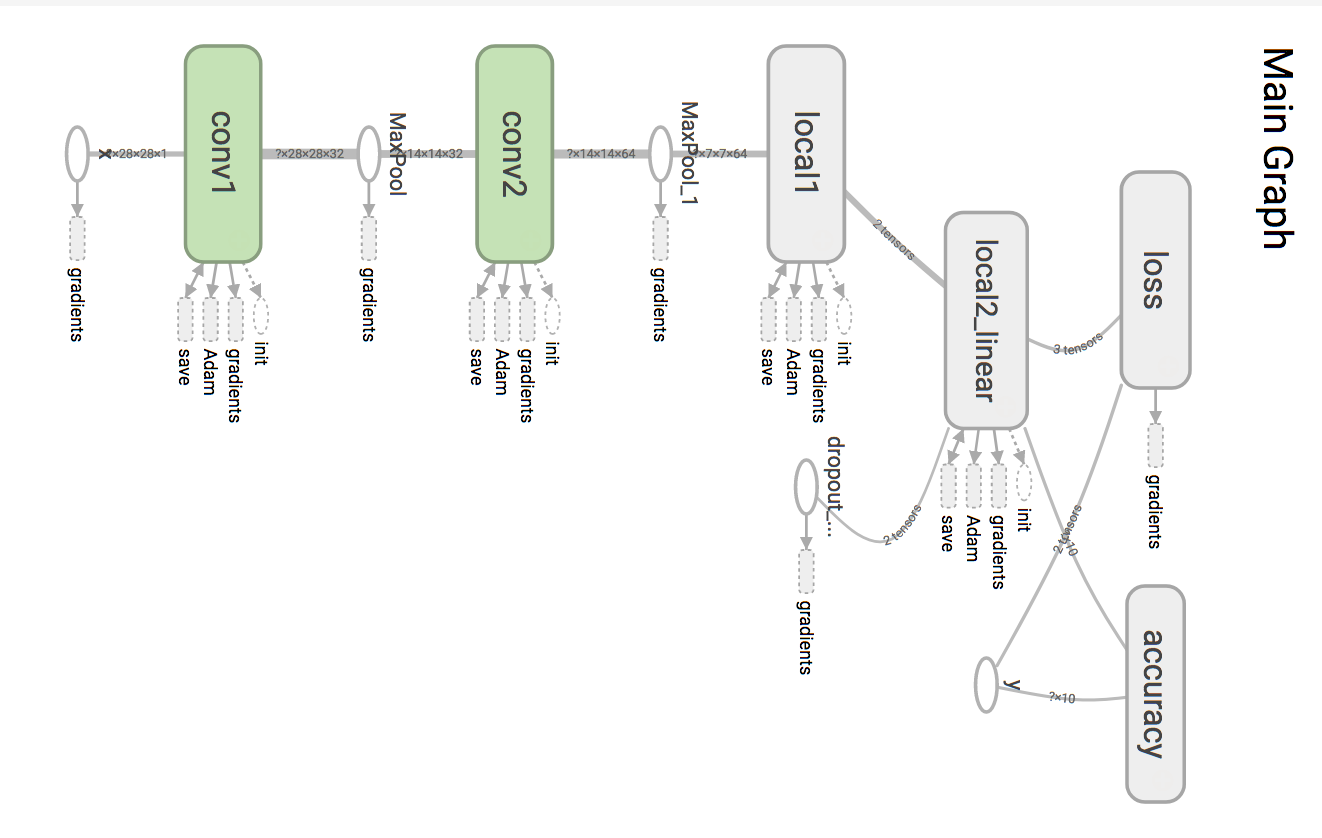

Assume the input to the convolutional layer is a 4 dimensional tensor:
1. Image number
2. Y-axis of each image
3. X-axis of each image
4. Channels of each image

The output is another 4-dim tensor with the following dimensions:

1. Image number, same as input.
2. Y-axis of each image. If 2x2 pooling is used, then the height and width of the input images is divided by 2.
3. X-axis of each image. Ditto.
4. Channels produced by the convolutional filters.

In [ ]:
# creating a few helper functions! for the neural net.
# You don't necessarily need to have variable_scope... but it makes visualising the network easier with names and etc as shown above
# Plus debugging is nicer too.

def conv_Layer(input, num_input_channels, filter_size, num_filters, name):
    
    with tf.variable_scope(name) as scope:
        # Shape of the filter-weights for the convolution
        shape = [filter_size, filter_size, num_input_channels, num_filters]

        # Create new weights (filters) with the given shape (essentially starting off with random weights)
        weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))

        # Create new biases, one for each filter
        biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))
        
         '''Create the TensorFlow operation for convolution.
           Note the strides are set to 1 in all dimensions.
           The first and last stride must always be 1,
           because the first is for the image-number and
           the last is for the input-channel.
           
           But e.g. strides=[1, 2, 2, 1] would mean that the filter
           is moved 2 pixels across the x- and y-axis of the image.
           The padding is set to 'SAME' which means the input image
           is padded with zeroes so the size of the output is the same.'''

        # TensorFlow operation for convolution
        out_layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
        
        
        # Add the biases to the results of the convolution.
        out_layer += biases
        
        return out_layer, weights

# Creating a pooling layer

def pooling_layer(input, name):
    
    with tf.variable_scope(name) as scope:
        # TensorFlow operation for pooling
        
        ''' This is 2x2 max-pooling, which means that we
        consider 2x2 windows and select the largest value
        in each window. Then we move 2 pixels to the next window.'''
        
        layer = tf.nn.max_pool(value=input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        return layer
    
# after convolution we want to add fully connected layers, however before doing so we need
# flatten the output 4-dimension tensor to 2 dimensional which will be used as input to the fully connected layer.

def flatten_layer(layer):
    # get the shape of the layer I want to flatten:
    
    layer_shape= layer.get_shape()
    
    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features
    
def FCN(input, num_inputs, num_outputs, name):
    with tf.variable_scope(name) as scope:

        # Create new weights and biases.
        weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))
        
        # Multiply the input and weights, and then add the bias-values.
        layer = tf.matmul(input, weights) + biases
        
        return layer
    
# Oh and to ensure I have an element of choice about where I want to activate, I will
# also create a separate activation layer
def activation_layer(input, name):
    
    with tf.variable_scope(name) as scope:
        # TensorFlow operation for convolution
        layer = tf.nn.relu(input)
        
        return layer
    
######################### Now I can define my model sequentially ####################
# Convolutional Layer 1
layer_conv1, weights_conv1 = new_conv_layer(input=x_image, num_input_channels=1, filter_size=5, num_filters=6, name ="conv1")

# Pooling Layer 1
layer_pool1 = new_pool_layer(layer_conv1, name="pool1")

# RelU layer 1
layer_relu1 = activation_layer(layer_pool1, name="relu1")

# Convolutional Layer 2
layer_conv2, weights_conv2 = new_conv_layer(input=layer_relu1, num_input_channels=6, filter_size=5, num_filters=16, name= "conv2")

# Pooling Layer 2
layer_pool2 = new_pool_layer(layer_conv2, name="pool2")

# RelU layer 2
layer_relu2 = activation_layer(layer_pool2, name="relu2")

# Flatten Layer
num_features = layer_relu2.get_shape()[1:4].num_elements()
layer_flat = tf.reshape(layer_relu2, [-1, num_features])

# Fully-Connected Layer 1
layer_fc1 = new_fc_layer(layer_flat, num_inputs=num_features, num_outputs=128, name="fc1")

# RelU layer 3
layer_relu3 = activation_layer(layer_fc1, name="relu3")

# Fully-Connected Layer 2
layer_fc2 = new_fc_layer(input=layer_relu3, num_inputs=128, num_outputs=10, name="fc2")



### the following is the implementation of the same network, using the
### tf.layers API

In [ ]:
def ConvNet_Model(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    # takes the following arguments: batch_size, image_width, image_height, channels
    # MNIST dataset is made of monochrome 28 by 28 pixel images 
   
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(inputs=input_layer, filters=32, kernel_size=[5, 5],
                              padding="same",activation=tf.nn.relu)
    # 32, 5by5 filters.
    
    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[5, 5],
                              padding="same", activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer (flatten first)  
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, 
                                training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer (final layer)
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

the following web links were used for help:
https://www.tensorflow.org/tutorials/layers
https://www.tensorflow.org/api_docs/python/tf/layers
http://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/
http://cv-tricks.com/tensorflow-tutorial/training-convolutional-neural-network-for-image-classification/
https://github.com/aymericdamien/TensorFlow-Examples
https://medium.com/data-science-group-iitr/building-a-convolutional-neural-network-in-python-with-tensorflow-d251c3ca8117

to see how to write good code on this:
https://hackernoon.com/deep-learning-cnns-in-tensorflow-with-gpus-cba6efe0acc2
http://www.machinelearninguru.com/deep_learning/tensorflow/neural_networks/cnn_classifier/cnn_classifier.html
